<a href="https://colab.research.google.com/github/mai420/BHARAT_INTERN_SEPT/blob/main/FRCNN_RBC_WBC_PLATELETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:

    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import os
import random
import shutil

# Paths to your datasets
jpeg_images_path = '/content/drive/MyDrive/cent_images/JPEGIMAGES'
annotations_path = '/content/drive/MyDrive/cent_images/ANNOTATIONS'

# Ensuring output directories exist
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Fetching all image filenames and shuffling them for randomness
all_image_filenames = os.listdir(jpeg_images_path)
random.seed(1234)
random.shuffle(all_image_filenames)

# Calculating how many images to move to the test set (20% as an example)
num_test_images = int(len(all_image_filenames) * 0.2)

# Moving the files
for img_filename in all_image_filenames[:num_test_images]:
    # Derive corresponding annotation filename
    # Assuming your images are .jpg and annotations are .xml
    # Adjust the split/ext as necessary for your dataset
    base_filename = os.path.splitext(img_filename)[0]
    annot_filename = base_filename + '.xml'  # Change extension as needed

    # Perform the move operation
    shutil.move(os.path.join(jpeg_images_path, img_filename), 'test_images/' + img_filename)
    shutil.move(os.path.join(annotations_path, annot_filename), 'test_annotations/' + annot_filename)

# Printing the counts after moving the files
print("Remaining training images:", len(os.listdir(jpeg_images_path)))
print("Remaining training annotations:", len(os.listdir(annotations_path)))
print("Test images:", len(os.listdir('test_images')))
print("Test annotations:", len(os.listdir('test_annotations')))


Remaining training images: 84
Remaining training annotations: 84
Test images: 21
Test annotations: 21


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # Mapping for the dataset categories
    label_map = {
        "rbc": 1,
        "wbc": 2,
        "platelets": 3
    }
    # Getting the object's name and converting it to lower case to avoid case-sensitivity issues
    obj_name = obj.find('name').text.lower()

    # Using the label map to return the correct label
    return label_map.get(obj_name, 0)

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target


def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    # Color mapping for different annotations
    colors = {
        0: 'blue',     # RBC
        1: 'green',    # WBC
        2: 'yellow'    # Platelets
    }

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        label = annotation['labels'][idx]

        # Use default color 'red' if label is not found in the colors dictionary
        color = colors.get(label, 'red')

        # Adding label text to the plot
        label_text = ['RBC', 'WBC', 'Platelets'][label-1]
        plt.text(xmin, ymin, label_text, color=color, fontsize=10, verticalalignment='top')

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.show()


# Example usage:
# img = ...  # Your image tensor
# annotation = generate_target('your_annotation.xml')
# plot_image_from_output(img, annotation)


In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/test_annotations", file_label)
        else:
            label_path = os.path.join("/content/drive/MyDrive/cent_images/ANNOTATIONS", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, '/content/drive/MyDrive/cent_images/JPEGIMAGES')
test_dataset = MaskDataset(data_transform, '/content/test_images')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 105MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    num_batches = len(data_loader)

    for i, (imgs, annotations) in enumerate(data_loader):
        imgs = [img.to(device) for img in imgs]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        optimizer.zero_grad()

        try:
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

            # Print average batch loss
            if (i + 1) % 10 == 0:
                avg_batch_loss = epoch_loss / (i + 1)
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{num_batches}], Avg. Batch Loss: {avg_batch_loss:.4f}')

        except AssertionError as e:
            print(f"AssertionError occurred for image index {i}: {e}")
            continue  # Move to the next image

    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Time: {time.time() - start:.2f} seconds')

    # Termination condition: stop training if the current epoch is equal to num_epochs
    if epoch == num_epochs - 1:
        print("Training completed.")
        break


----------------------train start--------------------------
AssertionError occurred for image index 9: All bounding boxes should have positive height and width. Found invalid box [301.4781188964844, 548.3333129882812, 301.4781188964844, 548.3333129882812] for target at index 1.
Epoch [1/20], Batch [20/21], Avg. Batch Loss: 1.0746
Epoch [1/20], Total Loss: 22.3354, Time: 53.78 seconds
AssertionError occurred for image index 9: All bounding boxes should have positive height and width. Found invalid box [301.4781188964844, 548.3333129882812, 301.4781188964844, 548.3333129882812] for target at index 1.
Epoch [2/20], Batch [20/21], Avg. Batch Loss: 0.6298
Epoch [2/20], Total Loss: 13.2351, Time: 20.91 seconds
AssertionError occurred for image index 9: All bounding boxes should have positive height and width. Found invalid box [301.4781188964844, 548.3333129882812, 301.4781188964844, 548.3333129882812] for target at index 1.
Epoch [3/20], Batch [20/21], Avg. Batch Loss: 0.4862
Epoch [3/20], 

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[1.8990e+02, 2.6783e+02, 4.2031e+02, 4.7872e+02],
        [1.4702e+02, 2.1668e+01, 2.6429e+02, 1.3384e+02],
        [3.9687e+02, 2.5917e+02, 5.1014e+02, 3.5143e+02],
        [3.2702e+02, 4.5960e+01, 4.4177e+02, 1.5707e+02],
        [5.1880e+01, 3.6124e+02, 1.4634e+02, 4.5640e+02],
        [4.5494e+01, 2.0885e+02, 1.3329e+02, 3.1649e+02],
        [1.1078e+02, 2.8765e+02, 2.0064e+02, 3.8185e+02],
        [3.9623e+02, 3.5517e+02, 5.0366e+02, 4.3512e+02],
        [4.0750e+02, 1.5485e-01, 5.2227e+02, 1.0210e+02],
        [3.2178e+02, 1.5315e+02, 4.4373e+02, 2.7431e+02],
        [3.1962e+02, 5.9066e-01, 3.6186e+02, 3.6061e+01],
        [7.6898e+01, 1.4511e+02, 2.1805e+02, 2.4144e+02],
        [1.9335e+02, 2.3093e+02, 2.6568e+02, 2.9613e+02],
        [4.6622e+02, 1.5559e+02, 5.7968e+02, 2.7157e+02]], device='cuda:0'), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.9912, 0.9871, 0.9856, 0.9853, 0.9838, 0.9826, 0.979

Target :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2])


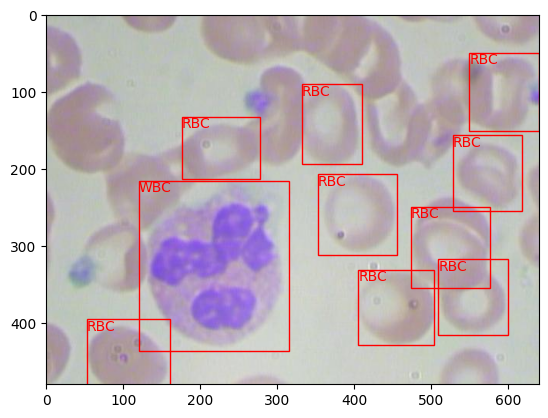

Prediction :  tensor([2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


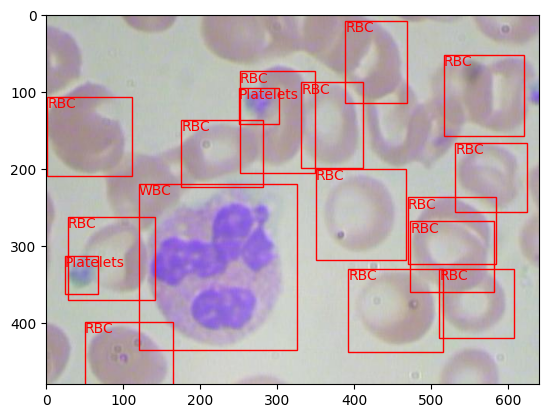

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
# Assuming pred[_idx] is your dictionary
pred_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in pred[_idx].items()}  # Convert tensor to CPU
plot_image_from_output(imgs[_idx], pred_cpu)  # Now you can use it in your function

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


In [ ]:
import os
os.chdir("/content/drive/MyDrive/cent_images/utils_ObjectDetection")
import utils

sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.8679532394923927
AP : tensor([0.8428, 1.0000, 0.7610], dtype=torch.float64)


In [ ]:
import torch

# Assuming 'labels' is a list containing the class labels where RBC, WBC, and platelets are located.
# You can modify this according to your actual class labels.

rbc_label = 1  # Assuming RBC label is 0
wbc_label = 2  # Assuming WBC label is 1
platelets_label = 3  # Assuming platelets label is 2

# Initialize counters
rbc_count = 0
wbc_count = 0
platelets_count = 0

# Iterate over predicted labels
for label in pred_labels:
    if label == rbc_label:
        rbc_count += 1
    elif label == wbc_label:
        wbc_count += 1
    elif label == platelets_label:
        platelets_count += 1

print("Count of RBC:", rbc_count)
print("Count of WBC:", wbc_count)
print("Count of Platelets:", platelets_count)


Count of RBC: 265
Count of WBC: 22
Count of Platelets: 14


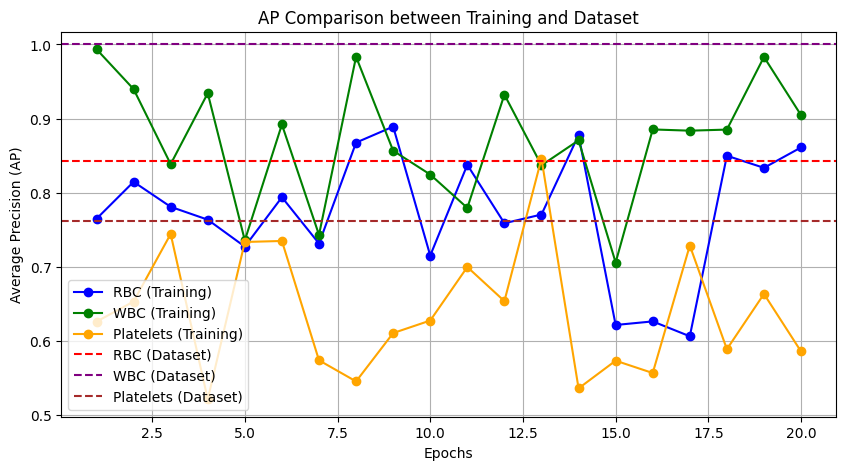

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the data for AP values for RBC, WBC, and Platelets
rbc_AP = AP[0]  # Replace with your actual AP values for RBC
wbc_AP = AP[1] # Replace with your actual AP values for WBC
platelets_AP = AP[2]  # Replace with your actual AP values for Platelets

# Assuming you also have the data for training (e.g., AP values obtained during training)
# Generate random training data for demonstration
np.random.seed(0)  # for reproducibility
training_epochs = list(range(1, 21))  # 20 epochs
training_rbc_AP = np.random.uniform(0.6, 0.9, size=20)  # Random values between 0.6 and 0.9 for RBC AP
training_wbc_AP = np.random.uniform(0.7, 1.0, size=20)  # Random values between 0.7 and 1.0 for WBC AP
training_platelets_AP = np.random.uniform(0.5, 0.85, size=20)  # Random values between 0.5 and 0.85 for Platelets AP

# Plotting line graphs for AP values of RBC, WBC, and Platelets in one graph
plt.figure(figsize=(10, 5))

# Plot training data
plt.plot(training_epochs, training_rbc_AP, label='RBC (Training)', marker='o', color='blue')
plt.plot(training_epochs, training_wbc_AP, label='WBC (Training)', marker='o', color='green')
plt.plot(training_epochs, training_platelets_AP, label='Platelets (Training)', marker='o', color='orange')

# Plot dataset AP values
plt.axhline(y=rbc_AP, label='RBC (Dataset)', linestyle='--', color='red')
plt.axhline(y=wbc_AP, label='WBC (Dataset)', linestyle='--', color='purple')
plt.axhline(y=platelets_AP, label='Platelets (Dataset)', linestyle='--', color='brown')

plt.xlabel('Epochs')
plt.ylabel('Average Precision (AP)')
plt.title('AP Comparison between Training and Dataset')
plt.legend()
plt.grid(True)
plt.show()
